https://www.kaggle.com/datasets/marquis03/fruits-100/data

In [1]:
import torch
import torchvision
import json

from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchinfo import summary

print(torch.__version__)
print(torchvision.__version__)

2.3.0.dev20240120+cu121
0.18.0.dev20240120+cu121


In [2]:
import os
import shutil
import random
import matplotlib.pyplot as plt
import glob
import numpy as np

from sklearn.model_selection import train_test_split
from pathlib import Path

In [3]:
# Set the device
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
### import custom scripts
from scripts import engine_classification, custom_dataset

In [5]:
# root path
root_path = Path(os.getcwd())
print(root_path)

# directories
train_dir = root_path / "dataset_subset" / "train"
val_dir = root_path / "dataset_subset" / "val"
test_dir = root_path / "dataset" / "test"

/mnt/DiscoD/00_Learning/00_ArtificialIntelligence/AI_Aplications/11_Fruits100


In [6]:
classes_all = os.listdir(root_path / "dataset/train")
len(classes_all)

101

In [7]:
# sample of classes
classes=[]
for i in [5,7,8,13,19,24,26,31,33,40,41,43,45,52,63,64,68,71,73,74,76,78,100]:
    classes.append(classes_all[i])
len(classes)

23

In [8]:
# save class file
with open("classes", "w") as fj:
    json.dump(classes, fj)

In [9]:
print(classes)

['apple', 'avocado', 'banana', 'black_berry', 'cherimoya', 'coconut', 'cranberry', 'dragonfruit', 'eggplant', 'grape', 'grapefruit', 'grenadilla', 'hard_kiwi', 'jalapeno', 'mandarine', 'mango', 'morinda', 'olive', 'papaya', 'passion_fruit', 'pineapple', 'pomegranate', 'pea']


### create_data_splits_dir

In [10]:
# create_data_splits_dir

def create_data_splits_dir(target_dir, target_ratio, dest_dir, classes):
    
    [os.makedirs(os.path.join(dest_dir, folder), exist_ok=True) for folder in classes];

    # Iterate through each class
    for class_name in classes:
        class_path = target_dir / class_name
        
        image_extensions = ['*.jpg', '*.jpeg', '*.png']
        # Get all image files with common extensions
        images = [file for ext in image_extensions for file in Path(class_path).rglob(ext)]
        # Shuffle the images to get a random sample
        random.shuffle(images)
    
        # Calculate the number of images for split
        num_images = len(images)
        num_samples = int(target_ratio * num_images)
    
        # Create symbolic links in target_dir
        for image in images[:num_samples]:
            src_path = image
            dst_path = dest_dir / class_name / image.name
            os.symlink(src_path, dst_path)

# create
#create_data_splits_dir(root_path / "dataset/train", 1, train_dir, classes) # ratio of train folder
#create_data_splits_dir(root_path / "dataset/val", 1, val_dir, classes) # ratio of val folder

### Setup model

In [11]:
# Initialize model with the best available weights
weights = torchvision.models.RegNet_Y_16GF_Weights.DEFAULT
model = torchvision.models.regnet_y_16gf(weights=weights).to(device)
model.fc

Linear(in_features=3024, out_features=1000, bias=True)

In [12]:
# Freeze all of the base layers in model
for param in model.parameters():
  param.requires_grad = False

In [13]:
# Update the classifier head to our class
from torch import nn

torch.manual_seed(42)
torch.cuda.manual_seed(42)

model.fc = nn.Sequential(
    nn.Linear(in_features=3024, out_features=len(classes))).to(device) 

model.fc

Sequential(
  (0): Linear(in_features=3024, out_features=23, bias=True)
)

In [14]:
transform_RegNet = weights.transforms()
transform_RegNet

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

### Setup Dataset / DataLoaders

In [15]:
# Create training and testing Dataset, and get a list of class names
train_data = custom_dataset.CustomDataset_classification(targ_dir=train_dir, transform=transform_RegNet)
val_data = custom_dataset.CustomDataset_classification(targ_dir=val_dir, transform=transform_RegNet)
test_data = custom_dataset.CustomDataset_classification(targ_dir=test_dir, transform=transform_RegNet)

class_names = train_data.classes
len(class_names)

23

In [16]:
# Turn data custom Datasets into DataLoaders
BATCH_SIZE = 24

train_dataloader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, num_workers=0, shuffle=True) 
test_dataloader  = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, num_workers=0, shuffle=False) 
val_dataloader  = DataLoader(dataset=val_data, batch_size=BATCH_SIZE, num_workers=0, shuffle=False)

train_dataloader, test_dataloader, val_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7ff84d2a5250>,
 <torch.utils.data.dataloader.DataLoader at 0x7ff8894db8c0>)

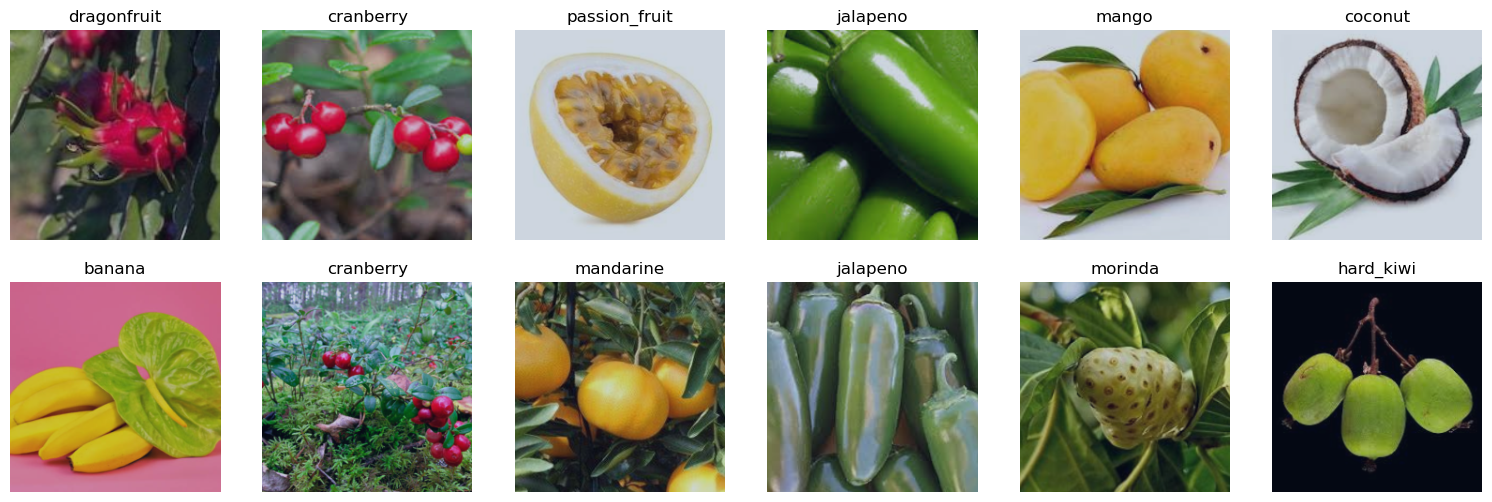

In [17]:
# visualize a batch of train data loader
images, labels = next(iter(train_dataloader))
images = images.numpy() # convert images to numpy for display

fig = plt.figure(figsize=(19, 6))
rows, cols = 2, 6
for i in range(0, rows * cols):
    ax = fig.add_subplot(rows, cols, i+1)
    image_ = np.transpose(images[i], (1, 2, 0)) 
    image_ = image_*[0.18]+[0.4] # unnormalize 
    plt.imshow(image_)
    plt.title(class_names[labels[i].item()])
    plt.axis(False);

### Train model

In [18]:
class EarlyStopping:
    def __init__(self, tolerance=3, patience=5, min_delta=0.001):
        self.tolerance = tolerance
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False
        self.best_metric = None

    def __call__(self, validation_loss, validation_metric):
        # Check for improvement in validation metric
        if (self.best_metric is None or
                validation_metric - self.best_metric > self.min_delta):
            self.best_metric = validation_metric
            self.counter = 0
        else:
            self.counter += 1

        # Early stopping based on patience and tolerance
        if self.counter >= self.tolerance and self.patience > 0:
            self.early_stop = True

In [19]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, 
                                                       threshold=0.0001, threshold_mode='rel')
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
early_stopping = EarlyStopping(tolerance=3, patience=5, min_delta=0.001)  # Adjust parameters

In [20]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

EPOCHS = 20
# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results = engine_classification.run_model(model=model,
                       train_dataloader=train_dataloader,
                       validation_dataloader=val_dataloader, 
                       optimizer=optimizer,
                       scheduler=scheduler,
                       early_stopping=early_stopping,
                       loss_fn=loss_fn,
                       epochs=EPOCHS,
                       device=device)

# End the timer
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/20 [00:00<?, ?it/s]

Training Step: 0it [00:00, ?it/s]

Validation Step: 0it [00:00, ?it/s]

Epoch: 1 | lr: 0.001 | train_loss: 0.9783 | train_acc: 0.7854 | validation_loss: 0.5270 | validation_acc: 0.8723
model saved at epoch: 1


Training Step: 0it [00:00, ?it/s]

Validation Step: 0it [00:00, ?it/s]

Epoch: 2 | lr: 0.001 | train_loss: 0.3735 | train_acc: 0.9053 | validation_loss: 0.3998 | validation_acc: 0.8958
model saved at epoch: 2


Training Step: 0it [00:00, ?it/s]

Validation Step: 0it [00:00, ?it/s]

Epoch: 3 | lr: 0.001 | train_loss: 0.2641 | train_acc: 0.9342 | validation_loss: 0.3467 | validation_acc: 0.9132
model saved at epoch: 3


Training Step: 0it [00:00, ?it/s]

Validation Step: 0it [00:00, ?it/s]

Epoch: 4 | lr: 0.001 | train_loss: 0.2094 | train_acc: 0.9460 | validation_loss: 0.3119 | validation_acc: 0.9201
model saved at epoch: 4


Training Step: 0it [00:00, ?it/s]

Validation Step: 0it [00:00, ?it/s]

Epoch: 5 | lr: 0.001 | train_loss: 0.1625 | train_acc: 0.9608 | validation_loss: 0.3115 | validation_acc: 0.9193
model saved at epoch: 5


Training Step: 0it [00:00, ?it/s]

Validation Step: 0it [00:00, ?it/s]

Epoch: 6 | lr: 0.001 | train_loss: 0.1397 | train_acc: 0.9666 | validation_loss: 0.2876 | validation_acc: 0.9314
model saved at epoch: 6


Training Step: 0it [00:00, ?it/s]

Validation Step: 0it [00:00, ?it/s]

Epoch: 7 | lr: 0.001 | train_loss: 0.1225 | train_acc: 0.9698 | validation_loss: 0.2910 | validation_acc: 0.9193


Training Step: 0it [00:00, ?it/s]

Validation Step: 0it [00:00, ?it/s]

Epoch: 8 | lr: 0.001 | train_loss: 0.1046 | train_acc: 0.9752 | validation_loss: 0.2767 | validation_acc: 0.9280
model saved at epoch: 8


Training Step: 0it [00:00, ?it/s]

Validation Step: 0it [00:00, ?it/s]

Epoch: 9 | lr: 0.001 | train_loss: 0.0922 | train_acc: 0.9782 | validation_loss: 0.2748 | validation_acc: 0.9245
model saved at epoch: 9
early stopping at epoch: 8
[INFO] Total training time: 5835.489 seconds


In [21]:
def plot_loss_curves(results):   
    loss = results["train_loss"]
    val_loss = results["validation_loss"]

    accuracy = results["train_acc"]
    val_accuracy = results["validation_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 4))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

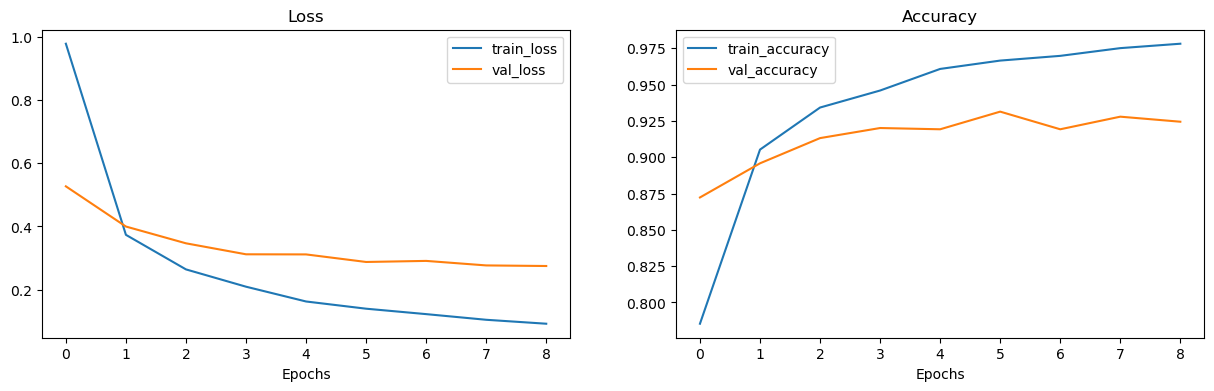

In [22]:
# Plot the loss curves of our model
plot_loss_curves(results)

In [23]:
#%load_ext tensorboard # line magic to load TensorBoard
#%tensorboard --logdir runs # run TensorBoard session with the "runs/" directory

# Inference / Load saved model

In [24]:
import torch
import torchvision
import json
import matplotlib.pyplot as plt
import os
import random

from PIL import Image
from pathlib import Path

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [25]:
# load model using full model saved
# load weights for getting transform
weights = torchvision.models.EfficientNet_V2_S_Weights.DEFAULT
transform = weights.transforms()
model_load = torch.load('models/model_full_EfficientNet_202402251632.pt') 
#model_load

In [26]:
# load classes file
with open("classes", "r") as fj:
    classes = json.load(fj)

In [27]:
def pred_and_plot_image(
    model: torch.nn.Module,
    image_path: str,
    class_names,
    transform,
    device):
       
    image = Image.open(image_path) # Load in image 
    
    image = transform(image).unsqueeze(0).to(device) # Transform the image, add batch dimension and put image on target device
    
    model.to(device) # model on the target device     
    model.eval() # Turn on model evaluation mode and inference mode
    
    pred_dict = {}
    
    with torch.no_grad():     
        pred_logit = model(image) # perform inference on target sample 
        pred_prob = torch.softmax(pred_logit, dim=1) # turn logits into prediction probabilities
        pred_label = torch.argmax(pred_prob, dim=1) # turn prediction probabilities into prediction label
        pred_class = class_names[pred_label.cpu()] # hardcode prediction class to be on CPU

        # put in the dictionary
        pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
        pred_dict["pred_class"] = pred_class
        
    # Plot the image
    plt.imshow(image.squeeze().permute(1, 2, 0).cpu().numpy()*[0.18]+[0.4]) # unnormalize  
    
    if class_names:
        title = f"Pred: {class_names[pred_label.cpu()]} | Prob: {pred_prob.max().cpu():.3f}"
    else:
        title = f"Pred: {pred_label} | Prob: {pred_prob.max().cpu():.3f}"
        
    plt.title(title)
    plt.axis(False)

    return pred_dict

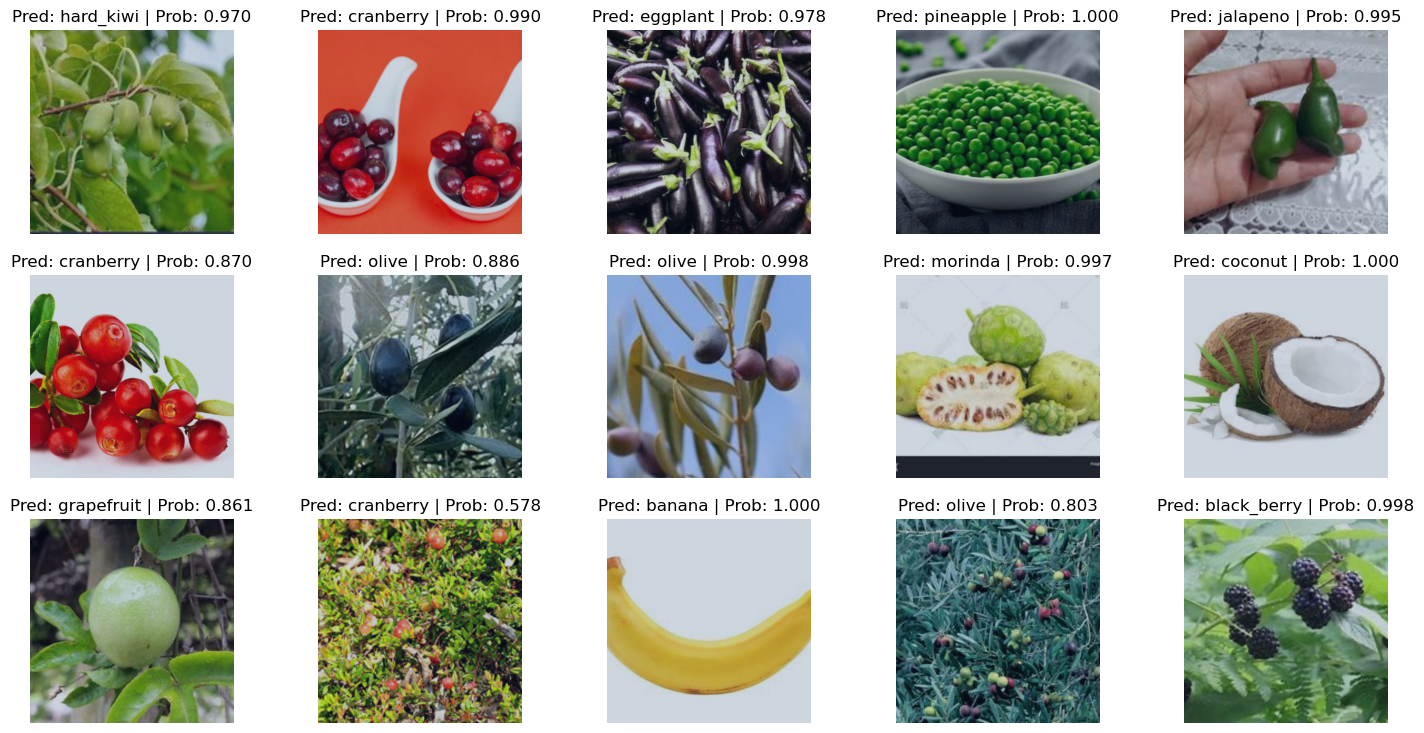

In [28]:
root_path = Path(os.getcwd())
# Get a list of all test image filepaths
test_dir = root_path / "dataset_subset" / "val"
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))

# Randomly select a test image path
img_paths = random.sample(test_data_paths, k=15)

fig = plt.figure(figsize=(18, 9))
rows, cols = 3, 5
for i in range(0, rows * cols):
    ax = fig.add_subplot(rows, cols, i+1)
    img = img_paths[i]
    pred_dict = pred_and_plot_image(model_load, img, classes, transform, device)

In [29]:
if torch.cuda.is_available():
    torch.cuda.empty_cache()